In [2]:
from collections import deque
import math
import random

import keras
import gym
from matplotlib import pyplot as plt

env_name = 'CartPole-v1'
env = gym.make(env_name).env
REPLAY_MEMORY_SIZE = 1e6
OBSERVATION_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
DISCOUNT_RATE = 0.99
EPSILON_MAX = 1.0
EPSILON_MIN = .01
ANNEALING_CONST = .001  # aka Lambda
MINIBATCH_SIZE = 64


class Memory(deque):
    def __init__(self, size):
        self.size = size

    def append(self, thing):
        if len(self) > self.size - 1:
            self.popleft()
        return super().append(thing)

    def sample(self, batch_size):
        batch_size = min(len(self), batch_size)
        return random.sample(self, batch_size)

def make_network():
    q_network = keras.Sequential()
    q_network.add(keras.layers.Dense(64, activation='relu', input_shape=OBSERVATION_SHAPE))
    q_network.add(keras.layers.Dense(NUM_ACTIONS, activation='linear'))    
    q_network.compile(optimizer=keras.optimizers.Adam(), loss='mse')
    return q_network

q_network = make_network()
replay_memory = Memory(REPLAY_MEMORY_SIZE)

/Users/liavkoren/Envs/ai-gym/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# An extremely minimal DQN implementation

Does not yet include target network. See below for version that does.

In [2]:
EPSILON = EPSILON_MAX
episode_count = 0
reward_hist = [] 
q_hist = []
epsilon_hist = []

RENDER = True
NUM_EPISODES = 5000
REPORT_EVERY= 10


def replay():
    # Q_network gives us Vals for all actions in one forward pass:
    batch = replay_memory.sample(MINIBATCH_SIZE)  # (batchsize x observation_shape)

    states = np.array([exp[0] for exp in batch])
    y = q_network.predict(states)

    terminal_state = np.zeros(OBSERVATION_SHAPE)
    states_ = np.array([exp[3] if exp[3] is not None else terminal_state for exp in batch])
    y_ = q_network.predict(states_)
    
    for idx, exp in enumerate(batch):
        state, action, reward, state_, terminal = exp        
        if state_ is None:
            y[idx, action] = reward
        else:
            y[idx, action] = reward + DISCOUNT_RATE * np.amax(y_[idx])
    q_network.fit(states, y, batch_size=64, epochs=1, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values. 
    

def Q_val_one(state):
    # The hard-coded [0] is sketchy here
    return q_network.predict(state.reshape((1, OBSERVATION_SHAPE[0]))).flatten()
    
    
def simple_dqn():
    steps = 0
    for episode_count in range(int(NUM_EPISODES)):
        episode_done = False
        episode_reward = 0
        state = env.reset()
        q_hist.append(Q_val_one(state).max())
        episode_trace = []
        if episode_count % REPORT_EVERY == 0:
            print('Starting episode %s ' % episode_count)
            q_network.save(env_name + '.h5')
                        
        while not episode_done:
            EPSILON = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN) * math.exp(-ANNEALING_CONST * steps)
            epsilon_hist.append(EPSILON)
            steps += 1
            if random.random() < EPSILON:
                action = random.randint(0, NUM_ACTIONS-1)
            else:
                action = Q_val_one(state).argmax()

            state_, reward, episode_done, _ = env.step(action)
            q_hist.append(Q_val_one(state).max())

            episode_reward += reward
            if RENDER:
                env.render()
            if episode_done:
                state_ = None
            replay_memory.append((state, action, reward, state_, episode_done))
            replay()
            state = state_
            if episode_done:
                if episode_count % REPORT_EVERY == 0:
                    print(episode_reward)            
                reward_hist.append(episode_reward)

simple_dqn()
print('done')

Starting episode 0 
14.0
Starting episode 10 
15.0
Starting episode 20 
14.0
Starting episode 30 
13.0
Starting episode 40 
10.0
Starting episode 50 
12.0
Starting episode 60 
61.0
done


## Using Adam:

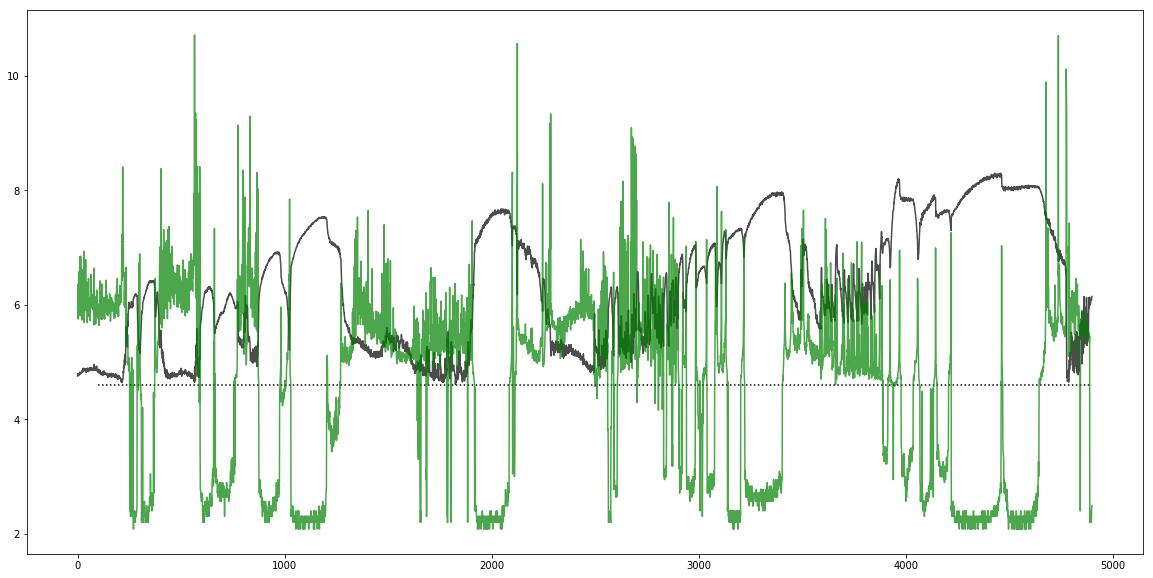

In [69]:
cut = 100
plt.figure(figsize=(20, 10))
plt.plot(np.log(q_hist[cut:]), color='k', alpha=.7)
plt.plot(np.log(reward_hist[cut:]), color='g', alpha=.7)

plt.hlines(np.log(100), cut, len(reward_hist)-cut, linestyles='dotted', )
plt.show()

## Using RMSProp:

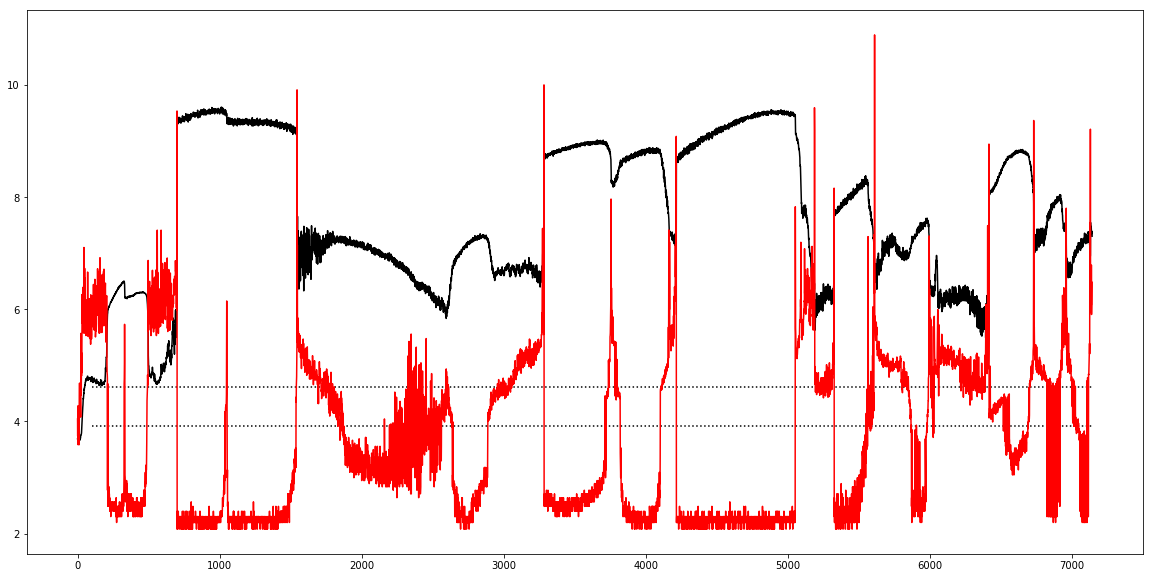

In [52]:
cut = 100
fig = plt.figure(figsize=(20, 10))
plt.plot(np.log(q_hist[cut:]), color='k')
plt.plot(np.log(reward_hist[cut:]), color='r')

plt.hlines(np.log(100), cut, len(reward_hist)-cut, linestyles='dotted')
plt.show()

In [12]:
steps = 0
reward_hist_target_net = [] 
q_hist_target_net = []
q_hist_primary_net = []
replay_memory_target_net = Memory(REPLAY_MEMORY_SIZE)
RENDER = True
NUM_EPISODES = 300
REPORT_EVERY= 10
UPDATE_TARGET_EVERY = 100
MAX_EPISODE_LEN = 2000


q_network = make_network()
target_network = make_network()
target_network.set_weights(q_network.get_weights())
replay_memory = Memory(REPLAY_MEMORY_SIZE)



def replay_with_target_net():
    batch = replay_memory_target_net.sample(MINIBATCH_SIZE)  # (batchsize x observation_shape)

    states = np.array([exp[0] for exp in batch])
    y = target_network.predict(states)

    terminal_state = np.zeros(OBSERVATION_SHAPE)
    states_ = np.array([exp[3] if exp[3] is not None else terminal_state for exp in batch])
    y_ = target_network.predict(states_)
    
    for idx, exp in enumerate(batch):
        state, action, reward, state_, terminal = exp        
        if state_ is None:
            y[idx, action] = reward
        else:
            y[idx, action] = reward + DISCOUNT_RATE * np.amax(y_[idx])
    q_network.fit(states, y, batch_size=64, epochs=1, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values. 
    

def Q_val_one(net, state):
    return net.predict(state.reshape((1, OBSERVATION_SHAPE[0]))).flatten()
    
    
def dqn_with_target_network():
    global steps, reward_hist_target_net, q_hist_target_net
    for episode_count in range(int(NUM_EPISODES)):
        episode_done = False
        episode_reward = 0
        state = env.reset()
        q_hist_target_net.append(Q_val_one(target_network, state).max())
        q_hist_primary_net.append(Q_val_one(q_network, state).max())
        episode_trace = []
        
        if episode_count % REPORT_EVERY == 0:
            print('Starting episode %s ' % episode_count)
            # q_network.save(env_name + '.h5')
            print('Steps: %d' % steps)
        episode_len = 0
        while not episode_done:
            episode_len += 1
            EPSILON = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN) * math.exp(-ANNEALING_CONST * steps)
            steps += 1
            
            if random.random() < EPSILON:
                action = random.randint(0, NUM_ACTIONS-1)
            else:
                action = Q_val_one(q_network, state).argmax()

            state_, reward, episode_done, _ = env.step(action)
            episode_reward += reward
            
            if RENDER:
                env.render()
            if episode_done:
                state_ = None
            
            replay_memory_target_net.append((state, action, reward, state_, episode_done))
            replay_with_target_net()
            state = state_

            if steps % UPDATE_TARGET_EVERY == 0:
                target_network.set_weights(q_network.get_weights())
            if episode_len > MAX_EPISODE_LEN:
                episode_done = True
            
            if episode_done:
                print(episode_reward)            
                reward_hist_target_net.append(episode_reward)

dqn_with_target_network()

Starting episode 0 
Steps: 0
21.0
18.0
9.0
28.0
35.0
14.0
17.0
10.0
17.0
26.0
Starting episode 10 
Steps: 195
30.0
24.0
14.0
14.0
12.0
17.0
14.0
14.0
20.0
17.0
Starting episode 20 
Steps: 371
15.0
13.0
17.0
27.0
16.0
12.0
14.0
22.0
8.0
12.0
Starting episode 30 
Steps: 527
13.0
10.0
14.0
11.0
14.0
9.0
12.0
16.0
23.0
18.0
Starting episode 40 
Steps: 667
27.0
13.0
12.0
11.0
9.0
16.0
12.0
15.0
9.0
9.0
Starting episode 50 
Steps: 800
12.0
14.0
12.0
12.0
8.0
12.0
9.0
9.0
12.0
17.0
Starting episode 60 
Steps: 917
10.0
12.0
12.0
13.0
10.0
13.0
11.0
14.0
11.0
12.0
Starting episode 70 
Steps: 1035
20.0
11.0
9.0
13.0
11.0
12.0
12.0
13.0
27.0
10.0
Starting episode 80 
Steps: 1173
13.0
14.0
11.0
21.0
17.0
11.0
12.0
13.0
26.0
9.0
Starting episode 90 
Steps: 1320
14.0
10.0
11.0
26.0
13.0
18.0
12.0
14.0
10.0
11.0
Starting episode 100 
Steps: 1459
11.0
10.0
22.0
12.0
26.0
10.0
14.0
20.0
14.0
15.0
Starting episode 110 
Steps: 1613
15.0
19.0
14.0
16.0
15.0
16.0
16.0
13.0
17.0
17.0
Starting episode 120 
S

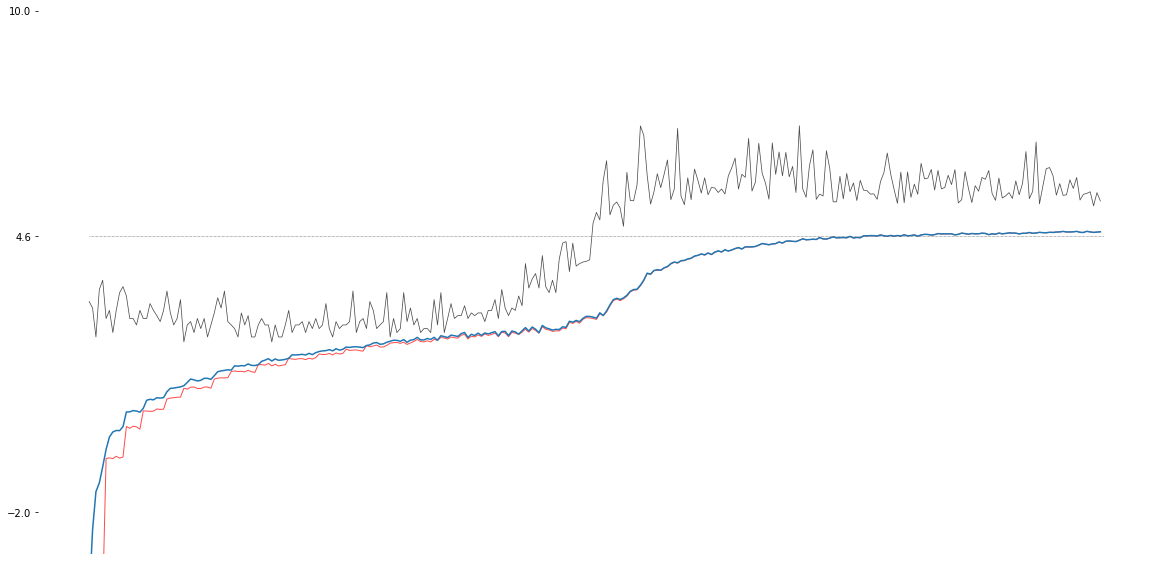

In [13]:
"""
reward_hist_target_net = [] 
q_hist_target_net = []
q_hist_primary_net = []
"""

cut = 0
fig, ax = plt.subplots(figsize=(20, 10))
for side in ['top', 'right', 'bottom', 'left']:    
    ax.spines[side].set_visible(False)

t
ax.set_ylim([-3, 10])
ax.yaxis.set_ticks([-2, np.log(100), 10])
plt.plot(np.log(reward_hist_target_net[cut:]), color='k', alpha=.7, linewidth=.75)
plt.plot(np.log(q_hist_target_net[cut:]), color='r', alpha=.7, linewidth=1)
plt.plot(np.log(q_hist_primary_net[cut:]) )
plt.hlines(np.log(100), 0, len(reward_hist_target_net)-cut, linestyles='dotted', linewidth=.5)
plt.show()

In [ ]:
q_hist_target_net = []
q_hist_primary_net = []
steps = 0

env_name = 'LunarLander-v2'
env = gym.make(env_name).env
REPLAY_MEMORY_SIZE = 1e6
OBSERVATION_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
SAVE_EVERY = 2000  # steps
RENDER_EVERY = 100


def double_dqn():
    
    replay_memory_with_ddqn = Memory(REPLAY_MEMORY_SIZE)
    RENDER = True
    NUM_EPISODES = 5000
    REPORT_EVERY= 10
    UPDATE_TARGET_EVERY = 100
    MAX_EPISODE_LEN = 2000
    USE_DDQN = True
    online_net = make_network()
    target_net = make_network()
    target_net.set_weights(online_net.get_weights())
    replay_memory = Memory(REPLAY_MEMORY_SIZE)


    def replay():
        # Bec of the way we've set up the online_net, it gives us Vals for all actions available in one forward 
        # pass.    
        batch = replay_memory_with_ddqn.sample(MINIBATCH_SIZE)  # (batchsize x observation_shape)

        states = np.array([exp[0] for exp in batch])
        y = target_net.predict(states)  # (batch x num-actions)

        terminal_state = np.zeros(OBSERVATION_SHAPE)
        states_ = np.array([exp[3] if exp[3] is not None else terminal_state for exp in batch])
        online_predicted_actions = online_net.predict(states).argmax(axis=1)
        y_ = target_net.predict(states_)

        for idx, exp in enumerate(batch):
            state, action, reward, state_, terminal = exp        
            if state_ is None:
                y[idx, action] = reward
            else:                
                if USE_DDQN:
                    best_action = online_predicted_actions[idx]
                    y[idx, action] = reward + DISCOUNT_RATE * y_[idx, best_action]
                else:
                    y[idx, action] = reward + DISCOUNT_RATE * np.amax(y_[idx])                    
                # t[a] = r + GAMMA * pTarget_[i][ numpy.argmax(p_[i]) ]
        online_net.fit(states, y, batch_size=64, epochs=1, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values. 


    def Q_val_one(net, state):
        return net.predict(state.reshape((1, OBSERVATION_SHAPE[0]))).flatten()


    def main_loop():
        """ 
        Target network + DDQN.
        """
        global steps, reward_hist_target_net, q_hist_target_net
        
        for episode_count in range(int(NUM_EPISODES)):
            episode_done = False
            episode_reward = 0
            state = env.reset()
            q_hist_target_net.append(Q_val_one(target_net, state).max())
            q_hist_primary_net.append(Q_val_one(online_net, state).max())
            episode_trace = []

            if episode_count % REPORT_EVERY == 0:
                print('Starting episode %s ' % episode_count)
                print('Steps: %d' % steps)
            if steps % SAVE_EVERY == 0:                
                online_net.save(env_name + 'online-net.ht')
                target_net.save(env_name + 'target-net.ht')
            episode_len = 0
            while not episode_done:
                episode_len += 1
                EPSILON = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN) * math.exp(-ANNEALING_CONST * steps)
                steps += 1

                if random.random() < EPSILON:
                    action = random.randint(0, NUM_ACTIONS-1)
                else:
                    action = Q_val_one(online_net, state).argmax()

                state_, reward, episode_done, _ = env.step(action)
                episode_reward += reward

                if RENDER and episode_count % RENDER_EVERY == 0:
                    env.render()
                if episode_done:
                    state_ = None

                replay_memory_with_ddqn.append((state, action, reward, state_, episode_done))
                replay()
                state = state_

                if steps % UPDATE_TARGET_EVERY == 0:
                    target_net.set_weights(online_net.get_weights())
                if episode_len > MAX_EPISODE_LEN:
                    episode_done = True

                if episode_done:
                    print(episode_reward)            
                    reward_hist_target_net.append(episode_reward)
    main_loop()


double_dqn()

## Starting a training run from a new cell should never clobber state in older cells . 

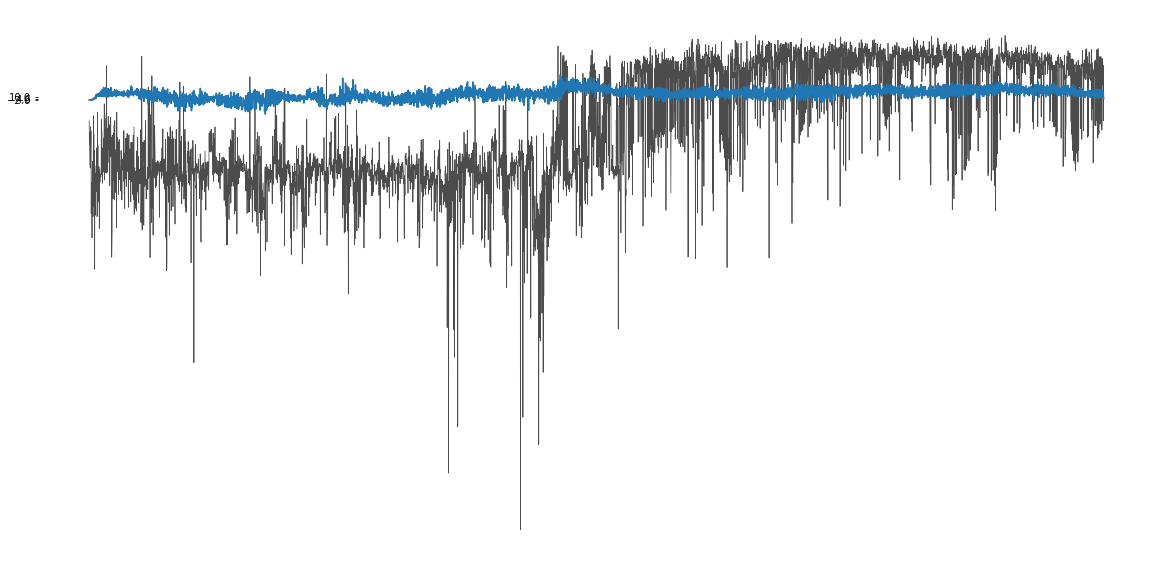

In [30]:
cut = 0
fig, ax = plt.subplots(figsize=(20, 10))
for side in ['top', 'right', 'bottom', 'left']:    
    ax.spines[side].set_visible(False)

# ax.xaxis.set_ticks([])
# ax.set_ylim([-3, 10])
ax.yaxis.set_ticks([-2, np.log(100), 10])
plt.plot(reward_hist_target_net[cut:], color='k', alpha=.7, linewidth=.75)
plt.plot(q_hist_target_net[cut:], color='r', alpha=.7, linewidth=1)
plt.plot(q_hist_primary_net[cut:])
plt.show()

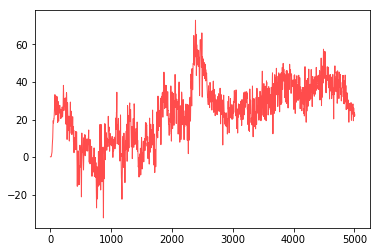

In [38]:
numpy = np
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError

    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y



plt.plot(smooth(np.array(q_hist_target_net[0:-1])), color='r', alpha=.7, linewidth=1)

(array([1.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 1.100e+01, 8.900e+01,
        5.830e+02, 1.927e+03, 4.160e+02, 1.964e+03]),
 array([-1689.10290206, -1494.80770276, -1300.51250346, -1106.21730416,
         -911.92210486,  -717.62690557,  -523.33170627,  -329.03650697,
         -134.74130767,    59.55389163,   253.84909093]),
 <a list of 10 Patch objects>)

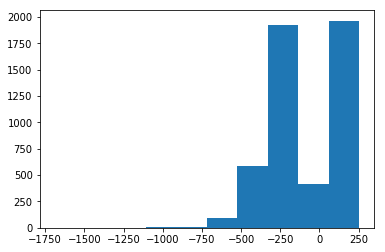

In [46]:
np.array(q_hist_target_net[0:-1]).argmax()
rewards = np.array(reward_hist_target_net)
plt.hist(rewards, bins=10)


# Vectorized DDQN version

In [41]:
episode_rewards = [] 
q_hist_target_net2 = []
q_hist_primary_net2 = []
steps = 0

lunar = 'LunarLander-v2'
cartpole = 'CartPole-v1'
env = gym.make(cartpole).env
REPLAY_MEMORY_SIZE = 1e5
OBSERVATION_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
SAVE_EVERY = 2000  # steps
RENDER_EVERY = 100


def double_dqn():
    
    replay_memory_with_ddqn = Memory(REPLAY_MEMORY_SIZE)
    RENDER = True
    NUM_EPISODES = 500
    REPORT_EVERY= 10
    UPDATE_TARGET_EVERY = 100
    MAX_EPISODE_LEN = 2000
    USE_DDQN = True
    online_net = make_network()
    target_net = make_network()
    online_net.load_weights(env_name + 'online-net.ht')
    target_net.load_weights(env_name + 'target-net.ht')
    replay_memory = Memory(REPLAY_MEMORY_SIZE)


    def replay():
        # Bec of the way we've set up the online_net, it gives us Vals for all actions available in one forward 
        # pass.    
        batch = replay_memory_with_ddqn.sample(MINIBATCH_SIZE)  # (batchsize x observation_shape)

        states = np.array([exp[0] for exp in batch])
        y = target_net.predict(states)  # (batch x num-actions)

        terminal_state = np.zeros(OBSERVATION_SHAPE)
        states_ = np.array([exp[3] if exp[3] is not None else terminal_state for exp in batch])
        online_predicted_actions = online_net.predict(states).argmax(axis=1)
        y_ = target_net.predict(states_)

        for idx, exp in enumerate(batch):
            state, action, reward, state_, terminal = exp        
            if state_ is None:
                y[idx, action] = reward
            else:                
                if USE_DDQN:
                    best_action = online_predicted_actions[idx]
                    y[idx, action] = reward + DISCOUNT_RATE * y_[idx, best_action]
                else:
                    y[idx, action] = reward + DISCOUNT_RATE * np.amax(y_[idx])                    
                # t[a] = r + GAMMA * pTarget_[i][ numpy.argmax(p_[i]) ]
        online_net.fit(states, y, batch_size=64, epochs=1, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values. 
            
    def replay_vectorized():
        batch = replay_memory_with_ddqn.sample(MINIBATCH_SIZE)
        # unpack all the replay memories into arrays:
        states = np.array([transition[0] for transition in batch])  # (batch x state-size)
        transition_actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])  # (batch x 1)
        terminal_mask = np.array([True if transition[3] is None else False for transition in batch])  # (batch x 1)
        terminal_state = np.zeros(OBSERVATION_SHAPE)
        states_ = np.array([transition[3] if transition[3] is not None else terminal_state for transition in batch])  # (batch x state-size)

        y = target_net.predict(states)  # (batch x num-actions)            
        online_predicted_actions = online_net.predict(states).argmax(axis=1)  # batch x num-action
        y_ = target_net.predict(states_)  # (batch x num-actions)
        
        # set y = r for terminal states:
        terminal_state_actions = transition_actions[terminal_mask]
        y[terminal_mask, terminal_state_actions] = rewards[terminal_mask]

        # DDQN update:
        # set y = r + gamma * Q_hat(s', argmax Q(s', a'))
        non_terminal_mask = ~terminal_mask
        best_actions = online_predicted_actions[non_terminal_mask]
        non_terminal_actions = transition_actions[non_terminal_mask]
        y[non_terminal_mask, non_terminal_actions] = rewards[non_terminal_mask] + DISCOUNT_RATE * y_[non_terminal_mask, best_actions] 
        online_net.fit(states, y, batch_size=MINIBATCH_SIZE, epochs=1, verbose=0)  # REMEBER, Q is a func from (state, action) pairs to values.         


    def Q_val_one(net, state):
        return net.predict(state.reshape((1, OBSERVATION_SHAPE[0]))).flatten()


    def main_loop():
        """ 
        Target network + DDQN.
        """
        global steps, reward_hist_target_net, q_hist_target_net2
        
        for episode_count in range(int(NUM_EPISODES)):
            episode_done = False
            episode_reward = 0
            state = env.reset()
            q_hist_target_net2.append(Q_val_one(target_net, state).max())
            q_hist_primary_net2.append(Q_val_one(online_net, state).max())
            episode_trace = []

            if episode_count % REPORT_EVERY == 0:
                print('Starting episode %s ' % episode_count, end='', flush=True)
                print('\n\tSteps: %d' % steps, end='', flush=True)
            if steps % SAVE_EVERY == 0:                
                online_net.save(env_name + 'online-net.ht')
                target_net.save(env_name + 'target-net.ht')
            episode_len = 0
            while not episode_done:
                episode_len += 1
                EPSILON = EPSILON_MIN + (EPSILON_MAX - EPSILON_MIN) * math.exp(-ANNEALING_CONST * steps)
                steps += 1

                if random.random() < EPSILON:
                    action = random.randint(0, NUM_ACTIONS-1)
                else:
                    action = Q_val_one(online_net, state).argmax()

                state_, reward, episode_done, _ = env.step(action)
                episode_reward += reward

                if RENDER and episode_count % RENDER_EVERY == 0:
                    env.render()
                if episode_done:
                    state_ = None

                replay_memory_with_ddqn.append((state, action, reward, state_, episode_done))
                replay_vectorized()
                state = state_

                if steps % UPDATE_TARGET_EVERY == 0:
                    target_net.set_weights(online_net.get_weights())
                if episode_len > MAX_EPISODE_LEN:
                    episode_done = True

                if episode_done:
                    print('\n\t' + str(episode_reward), end='', flush=True)            
                    episode_rewards.append(episode_reward)
    main_loop()


double_dqn()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Starting episode 0 
	Steps: 0
	13.0
	12.0
	9.0
	13.0
	28.0
	37.0
	17.0
	13.0
	23.0
	15.0Starting episode 10 
	Steps: 180
	13.0
	25.0
	20.0
	21.0
	33.0
	13.0
	15.0
	19.0
	13.0
	17.0Starting episode 20 
	Steps: 369
	14.0
	27.0
	11.0
	12.0
	34.0
	12.0
	29.0
	13.0
	13.0
	14.0Starting episode 30 
	Steps: 548
	17.0
	15.0
	10.0
	12.0
	17.0
	17.0
	9.0
	14.0
	38.0
	18.0Starting episode 40 
	Steps: 715
	9.0
	14.0
	13.0
	10.0
	14.0
	11.0
	15.0
	13.0
	10.0
	10.0Starting episode 50 
	Steps: 834
	9.0
	24.0
	28.0
	13.0
	11.0
	9.0
	15.0
	12.0
	13.0
	10.0Starting episode 60 
	Steps: 978
	15.0
	15.0
	12.0
	10.0
	9.0
	9.0
	19.0
	11.0
	12.0
	8.0Starting episode 70 
	Steps: 1098
	13.0
	12.0
	10.0
	21.0
	9.0
	13.0
	13.0
	16.0
	14.0
	14.0Starting episode 80 
	Steps: 1233
	11.0
	21.0
	10.0
	12.0
	12.0
	32.0
	12.0
	16.0
	29.0
	20.0Starting episode 90 
	Steps: 1408
	14.0
	18.0
	16.0
	34.0
	34.0
	49.0
	53.0
	119.0


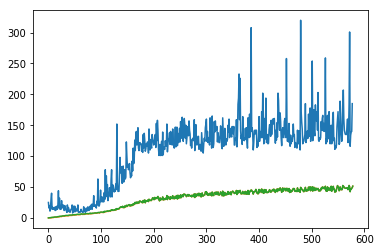

In [35]:
plt.plot(episode_rewards)
plt.plot(q_hist_target_net2)
plt.plot(q_hist_primary_net2)
# plt.plot(reward_hist_target_net)


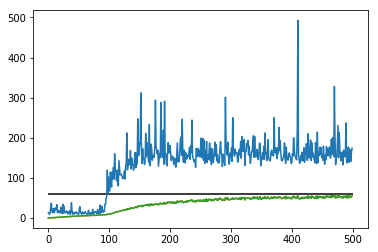

In [42]:
plt.plot(episode_rewards)
plt.plot(q_hist_target_net2)
plt.plot(q_hist_primary_net2)
plt.hlines(60, 0, len(episode_rewards))
env.close()